In [1]:
import tensorflow as tf
from censai import RayTracer, AnalyticalPhysicalModel, PhysicalModel
from censai.data.alpha_tng import decode_train, decode_physical_info
from censai.utils import nullwriter, plot_to_image, raytracer_residual_plot as residual_plot
import os, glob
import math
import numpy as np
from datetime import datetime
import random, time
from argparse import ArgumentParser
import json
import pandas as pd
from tensorboard.plugins.hparams import api as hp
gpus = tf.config.list_physical_devices('GPU')

""" # NOTE ON THE USE OF MULTIPLE GPUS #
Double the number of gpus will not speed up the code. In fact, doubling the number of gpus and mirroring 
the ops accross replicas means the code is TWICE as slow.

In fact, using multiple gpus means one should at least multiply the batch size by the number of gpus introduced, 
and optimize hyperparameters accordingly (learning rate should be scaled similarly).
"""
if len(gpus) == 1:
    STRATEGY = tf.distribute.OneDeviceStrategy(device="/gpu:0")
elif len(gpus) > 1:
    STRATEGY = tf.distribute.MirroredStrategy()
wndb = False

In [2]:
# import tensorflow as tf
# from censai.models.layers import UnetDecodingLayer, UnetEncodingLayer
# from censai.definitions import logkappa_normalization, log_kappa
# from censai.models.utils import get_activation


# class RayTracer(tf.keras.Model):
#     def __init__(
#             self,
#             pixels,
#             filter_scaling=1,
#             layers=4,
#             block_conv_layers=2,
#             kernel_size=3,
#             filters=32,
#             strides=2,
#             bottleneck_filters=None,
#             resampling_kernel_size=None,
#             upsampling_interpolation=False,     # use strided transposed convolution if false
#             kernel_regularizer_amp=0.,
#             bias_regularizer_amp=0.,            # if bias is used
#             activation="linear",
#             initializer="random_uniform",
#             use_bias=False,
#             kappalog=True,
#             normalize=False,
#             trainable=True,
#             name="ray_tracer",
#     ):
#         super(RayTracer, self).__init__(name=name)
#         self.trainable = trainable
#         self.kappalog = kappalog
#         self.kappa_normalize = normalize

#         common_params = {"padding": "same", "kernel_initializer": initializer,
#                          "data_format": "channels_last", "use_bias": use_bias,
#                          "kernel_regularizer": tf.keras.regularizers.L2(l2=kernel_regularizer_amp)}
#         if use_bias:
#             common_params.update({"bias_regularizer": tf.keras.regularizers.L2(l2=bias_regularizer_amp)})

#         resampling_kernel_size = resampling_kernel_size if resampling_kernel_size is not None else kernel_size
#         bottleneck_filters = bottleneck_filters if bottleneck_filters is not None else int(filter_scaling**(layers) * filters)

#         activation = get_activation(activation)

#         # compute size of bottleneck here
#         bottleneck_size = pixels // strides**(layers)

#         self.encoding_layers = []
#         self.decoding_layers = []
#         for i in range(layers):
#             self.encoding_layers.append(UnetEncodingLayer(
#                 kernel_size=kernel_size,
#                 downsampling_kernel_size=resampling_kernel_size,
#                 filters=int(filter_scaling**(i) * filters),
#                 strides=strides,
#                 conv_layers=block_conv_layers,
#                 activation=activation,
#                 **common_params
#             ))
#             self.decoding_layers.append(UnetDecodingLayer(
#                 kernel_size=kernel_size,
#                 upsampling_kernel_size=resampling_kernel_size,
#                 filters=int(filter_scaling**(i) * filters),
#                 conv_layers=block_conv_layers,
#                 strides=strides,
#                 activation=activation,
#                 bilinear=upsampling_interpolation,
#                 **common_params
#             ))

#         # reverse decoding layers order
#         self.decoding_layers = self.decoding_layers[::-1]

#         self.bottleneck_layer1 = tf.keras.layers.Conv2D(
#             filters=bottleneck_filters,
#             kernel_size=2*bottleneck_size,  # we perform a convolution over the full image at this point,
#             activation="linear",
#             **common_params
#         )
#         self.bottleneck_layer2 = tf.keras.layers.Conv2D(
#             filters=bottleneck_filters,
#             kernel_size=2*bottleneck_size,
#             activation="linear",
#             **common_params
#         )

#         self.output_layer = tf.keras.layers.Conv2D(
#             filters=2,
#             kernel_size=(1, 1),
#             activation="linear",
#             **common_params
#         )

#         if self.kappalog:
#             if self.kappa_normalize:
#                 self.kappa_link = tf.keras.layers.Lambda(lambda x: log_kappa(logkappa_normalization(x, forward=True)))
#             else:
#                 self.kappa_link = tf.keras.layers.Lambda(lambda x: log_kappa(x))
#         else:
#             self.kappa_link = tf.keras.layers.Lambda(lambda x: x)

#     def __call__(self, kappa):
#         return self.call(kappa)

#     def call(self, kappa):
#         kappa = self.kappa_link(kappa)
#         skip_connections = []
#         z = kappa
#         for i in range(len(self.encoding_layers)):
#             c_i, z = self.encoding_layers[i](z)
#             skip_connections.append(c_i)
#         skip_connections = skip_connections[::-1]
#         z = self.bottleneck_layer1(z)
#         z = self.bottleneck_layer2(z)
#         for i in range(len(self.decoding_layers)):
#             z = self.decoding_layers[i](z, skip_connections[i])
#         z = self.output_layer(z)
#         return z

#     def cost(self, kappa, alpha_true):
#         alpha_pred = self.call(kappa)
#         return tf.reduce_mean((alpha_pred - alpha_true) ** 2)


In [3]:

RAYTRACER_HPARAMS = [
    "pixels",
    "filter_scaling",
    "layers",
    "block_conv_layers",
    "kernel_size",
    "filters",
    "strides",
    "bottleneck_filters",
    "resampling_kernel_size",
    "upsampling_interpolation",
    "kernel_regularizer_amp",
    "activation",
    "initializer",
    "kappalog",
    "normalize",
]


def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # extract physical info from first example
    for image_fov, kappa_fov in dataset.map(decode_physical_info):
        break
    dataset = dataset.map(decode_train)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items))\
        .shuffle(buffer_size=args.buffer_size).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items))\
        .take(math.ceil((1 - args.train_split) * args.total_items)).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)

    # ========== Model and Physical Model =============================================================================
    # setup an analytical physical model to compare lenses from raytracer and analytical deflection angles.

    phys = PhysicalModel(pixels=args.pixels, image_fov=image_fov, kappa_fov=kappa_fov, src_fov=args.source_fov, psf_sigma=args.psf_sigma)
    with STRATEGY.scope():  # Replicate ops accross gpus
        ray_tracer = RayTracer(
            pixels=args.pixels,
            filter_scaling=args.filter_scaling,
            layers=args.layers,
            block_conv_layers=args.block_conv_layers,
            kernel_size=args.kernel_size,
            filters=args.filters,
            strides=args.strides,
            bottleneck_filters=args.bottleneck_filters,
            resampling_kernel_size=args.resampling_kernel_size,
            upsampling_interpolation=args.upsampling_interpolation,
            kernel_regularizer_amp=args.kernel_regularizer_amp,
            activation=args.activation,
            initializer=args.initializer,
            kappalog=args.kappalog,
            normalize=args.normalize,
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            args.initial_learning_rate,
            decay_steps=args.decay_steps,
            decay_rate=args.decay_rate,
            staircase=True)
        optim = tf.keras.optimizers.deserialize(
            {
                "class_name": args.optimizer,
                'config': {"learning_rate": lr_schedule}
            }
        )

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = args.logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    # setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            # save script parameter for future reference
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "ray_tracer_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RAYTRACER_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=ray_tracer)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
    else:
        save_checkpoint = False
    # =================================================================================================================
    def train_step(inputs):
        kappa, alpha = inputs
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            tape.watch(ray_tracer.trainable_weights)
            cost = tf.reduce_mean(tf.square(ray_tracer(kappa) - alpha), axis=(1, 2, 3))
            cost = tf.reduce_sum(cost) / args.batch_size    # normalize by global batch size
        gradient = tape.gradient(cost, ray_tracer.trainable_weights)
        if args.clipping:
            clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        else:
            clipped_gradient = gradient
        optim.apply_gradients(zip(clipped_gradient, ray_tracer.trainable_variables))
        return cost

    @tf.function
    def distributed_train_step(dist_inputs):
        per_replica_losses = STRATEGY.run(train_step, args=(dist_inputs,))
        cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        cost += tf.reduce_sum(ray_tracer.losses)
        return cost

    def test_step(inputs):
        kappa, alpha = inputs
        cost = tf.reduce_mean(tf.square(ray_tracer(kappa) - alpha), axis=(1, 2, 3))
        cost = tf.reduce_sum(cost) / args.batch_size    # normalize by global batch size
        return cost

    @tf.function
    def distributed_test_step(dist_inputs):
        per_replica_losses = STRATEGY.run(test_step, args=(dist_inputs,))
        # Replica losses are aggregated by summing them
        cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        cost += tf.reduce_sum(ray_tracer.losses)
        return cost
    # =================================================================================================================
    epoch_loss = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_lens_residuals": [],
#         "val_cost": [],
#         "val_lens_residuals": [],
        "learning_rate": [],
        "step": [],
        "wall_time": []
    }
    global_start = time.time()
    lastest_checkpoint = 1
    for epoch in range(1, args.epochs + 1):
        epoch_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, distributed_inputs in enumerate(train_dataset):
                start = time.time()
                cost = distributed_train_step(distributed_inputs)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
#                 tf.summary.scalar("Time per step", _time, step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
#                 tf.summary.scalar("MSE", cost, step=step)
                step += 1
            # Deflection angle residual
            kappa_true, alpha_true = distributed_inputs
            alpha_pred = ray_tracer.call(kappa_true)
            # Lens residual
            lens_true = phys.lens_source_func(kappa_true)
            lens_pred = phys.lens_source_func_given_alpha(alpha_pred, w=args.source_w)
            train_chi_squared = tf.reduce_mean(tf.square(lens_true - lens_pred))
            for res_idx in range(min(args.n_residuals, args.batch_size)):  # Residuals in train set
                tf.summary.image(f"Residuals {res_idx}",
                                 plot_to_image(residual_plot(alpha_true[res_idx], alpha_pred[res_idx], lens_true[res_idx], lens_pred[res_idx])), step=step)

            train_cost = epoch_loss.result().numpy()
            val_cost = val_loss.result().numpy()
            tf.summary.scalar("Time per step", time_per_step.result().numpy(), step=step)
#             tf.summary.scalar("Train lens residual", train_chi_squared, step=step)
#             tf.summary.scalar("Val lens residual", val_chi_squared, step=step)
            tf.summary.scalar("MSE", train_cost, step=step)
#             tf.summary.scalar("Val MSE", val_cost, step=step)
            tf.summary.scalar("Learning rate", optim.lr(step), step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} | learning rate {optim.lr(step).numpy():.2e} | "
              f"time per step {time_per_step.result():.2e} s")
        history["train_cost"].append(train_cost)
        history["train_lens_residuals"].append(train_chi_squared.numpy())
#         history["val_cost"].append(val_cost)
#         history["val_lens_residuals"].append(val_chi_squared.numpy())
        history["learning_rate"].append(optim.lr(step).numpy())
        history["step"].append(step)
        history["wall_time"].append(time.time() - global_start)
        # =============================================================================================================
        cost = train_cost if args.track_train else val_cost
        if cost < best_loss * (1 - args.tolerance):
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1

        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1)  # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
    return ray_tracer, phys, train_dataset, dataset, history, logname

In [4]:
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
parser = ArgumentParser()
parser.add_argument("--model_id",                   default="None",              help="Start training from previous "
                                                                                      "checkpoint of this model if provided")
parser.add_argument("--load_checkpoint",            default="best",              help="One of 'best', 'lastest' or the specific checkpoint index")
parser.add_argument("--datasets",                   required=True,  nargs="+",   help="Datasets to use, paths that contains tfrecords of dataset. User can provide multiple "
                                                                                      "directories to mix datasets")
parser.add_argument("--compression_type",           default=None,                help="Compression type used to write data. Default assumes no compression.")

# Model hyper parameters
parser.add_argument("--pixels",                         required=True,            type=int,     help="Size of input tensors, need to match dataset size!!")
parser.add_argument("--kernel_size",                    default=3,                type=int,     help="Main kernel size of U-net")
parser.add_argument("--filters",                        default=32,               type=int,     help="Number of filters of conv layers")
parser.add_argument("--filter_scaling",                 default=1,                type=float,   help="Scaling of the number of filters at each layers (1=no scaling)")
parser.add_argument("--layers",                         default=2,                type=int,     help="Number of layers of Unet (number of downsampling and upsampling")
parser.add_argument("--block_conv_layers",              default=2,                type=int,     help="Number of convolutional layers in a unet layer")
parser.add_argument("--strides",                        default=2,                type=int,     help="Strides of downsampling and upsampling layers")
parser.add_argument("--bottleneck_filters",             default=None,             type=int,     help="Number of filters of bottleneck layers. Default None, use normal scaling of filters.")
parser.add_argument("--resampling_kernel_size",         default=None,             type=int,     help="Kernel size of downsampling and upsampling layers. None, use same kernel size as the others.")
parser.add_argument("--upsampling_interpolation",       action="store_true",                    help="True: Use Bilinear interpolation for upsampling, False use Fractional Striding Convolution")
parser.add_argument("--kernel_regularizer_amp",         default=1e-3,             type=float,   help="l2 regularization on weights")
parser.add_argument("--kappalog",                       action="store_true",                    help="Input is log of kappa")
parser.add_argument("--normalize",                      action="store_true",                    help="Normalize log of kappa with max and minimum values defined in definitions.py")
parser.add_argument("--activation",                     default="linear",         type=str,     help="Non-linearity of layers")
parser.add_argument("--initializer",                    default="glorot_uniform", type=str,     help="Weight initializer")

# Training set params
parser.add_argument("-b", "--batch_size",               default=10,     type=int,               help="Number of images in a batch")
parser.add_argument("--train_split",                    default=0.8,    type=float,             help="Fraction of the training set")
parser.add_argument("--total_items",                    required=True,  type=int,               help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",                     default=None,                           help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",                   default=1,      type=int,               help="Number of example to read from each files.")
parser.add_argument("--buffer_size",                    default=1000,   type=int,               help="Buffer size for shuffling at each epoch.")


# Logs
parser.add_argument("--logdir",                         default="None",                         help="Path of logs directory.")
parser.add_argument("--logname",                        default=None,                           help="Name of the logs, default is 'RT_' + date")
parser.add_argument("--logname_prefixe",                default="RayTracer",                    help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",                      default="None",                         help="Directory where to save model weights")
parser.add_argument("--checkpoints",                    default=10,     type=int,               help="Save a checkpoint of the models each {%} iteration")
parser.add_argument("--max_to_keep",                    default=3,      type=int,               help="Max model checkpoint to keep")
parser.add_argument("--n_residuals",                    default=1,      type=int,               help="Number of residual plots to save. Add overhead at the end of an epoch only.")
parser.add_argument("--source_fov",                     default=10,     type=float,             help="Source fov for lens residuals")
parser.add_argument("--source_w",                       default=1,      type=float,             help="Width of gaussian of source gaussian")
parser.add_argument("--psf_sigma",                      default=0.04,   type=float,             help="Sigma of PSF for lens resiudal")

# Optimization params
parser.add_argument("-e", "--epochs",                   default=10,     type=int,               help="Number of epochs for training.")
parser.add_argument("--initial_learning_rate",          default=1e-3,   type=float,             help="Initial learning rate.")
parser.add_argument("--optimizer",                      default="Adam",                         help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--decay_rate",                     default=1.,     type=float,             help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",                    default=1000,   type=int,               help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--clipping",                       action="store_true",                    help="Clip backprop gradients between -10 and 10")
parser.add_argument("--patience",                       default=np.inf, type=int,               help="Number of step at which training is stopped if no improvement is recorder")
parser.add_argument("--tolerance",                      default=0,      type=float,             help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",                    action="store_true",                    help="Track training metric instead of validation metric, in case we want to overfit")
# parser.add_argument("--max_time",                       default=np.inf, type=float,             help="Time allowed for the training, in hours.")

# Reproducibility params
parser.add_argument("--seed",                           default=None,   type=int, help="Random seed for numpy and tensorflow")
parser.add_argument("--json_override",                  default=None,             help="A json filepath that will override every command line parameters. "
                                                                                       "Useful for reproducibility")


_StoreAction(option_strings=['--json_override'], dest='json_override', nargs=None, const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [5]:
import sys
sys.argv = ['']
args = parser.parse_args(
#   f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_TNG100 {os.getenv('HOME')}/scratch/Censai/data/alpha128_NIS "\
  f"--datasets {os.getenv('CENSAI_PATH')}/data/alpha128_512_hTNG_15k {os.getenv('CENSAI_PATH')}/data/alpha128_512_TNG {os.getenv('CENSAI_PATH')}/data/alpha128_512_SIE_15k "\
  f"--total_items=45000 "\
  f"--epochs=10 "\
  f"--train_split=0.95 "\
  f"--compression_type=GZIP "\
  f"--pixels=128 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.5 "\
  f"--decay_steps=10000 "\
  f"--kernel_size=5 "\
  f"--filters=84 "\
  f"--filter_scaling=1 "\
  f"--layers=4 "\
  f"--block_conv_layers=2 "\
  f"--strides=2 "\
#   f"--resampling_kernel_size=5 "\
  f"--kappalog "\
#   f"--normalize "\
  f"--upsampling_interpolation "\
  f"--clipping "\
  f"--kernel_regularizer_amp=0 "\
  f"--initializer=glorot_uniform "\
  f"--batch_size=10 "\
  f"--block_length=1 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('CENSAI_PATH')}/logs "\
  f"--logname_prefixe=RayTracer128_Interactive "\
  f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=10 "\
  f"--n_residuals=0 "\
  f"--patience=5 "\
  f"--tolerance=0.01 "\
  f"--seed=32 "
    "--track_train ".split()
)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
ray_tracer, phys, train_dataset, dataset, history, logname = main(args)
pd.DataFrame(history).to_csv(os.getenv('CENSAI_PATH')+f'/results/{logname}.csv')

epoch 1 | train loss 4.142e+03 | val loss 0.000e+00 | learning rate 1.00e-04 | time per step 1.88e-02 s
epoch 2 | train loss 1.808e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | time per step 8.90e-03 s
epoch 3 | train loss 1.388e-01 | val loss 0.000e+00 | learning rate 5.00e-05 | time per step 8.97e-03 s
epoch 4 | train loss 1.496e-01 | val loss 0.000e+00 | learning rate 5.00e-05 | time per step 8.83e-03 s
epoch 5 | train loss 1.286e-01 | val loss 0.000e+00 | learning rate 2.50e-05 | time per step 8.83e-03 s
epoch 6 | train loss 1.069e-01 | val loss 0.000e+00 | learning rate 2.50e-05 | time per step 8.85e-03 s
epoch 7 | train loss 1.025e-01 | val loss 0.000e+00 | learning rate 2.50e-05 | time per step 8.86e-03 s
epoch 8 | train loss 8.792e-02 | val loss 0.000e+00 | learning rate 1.25e-05 | time per step 8.87e-03 s
epoch 9 | train loss 8.773e-02 | val loss 0.000e+00 | learning rate 1.25e-05 | time per step 8.89e-03 s
Saved checkpoint for step 10: /home/aadam/scratch/Censai/models/

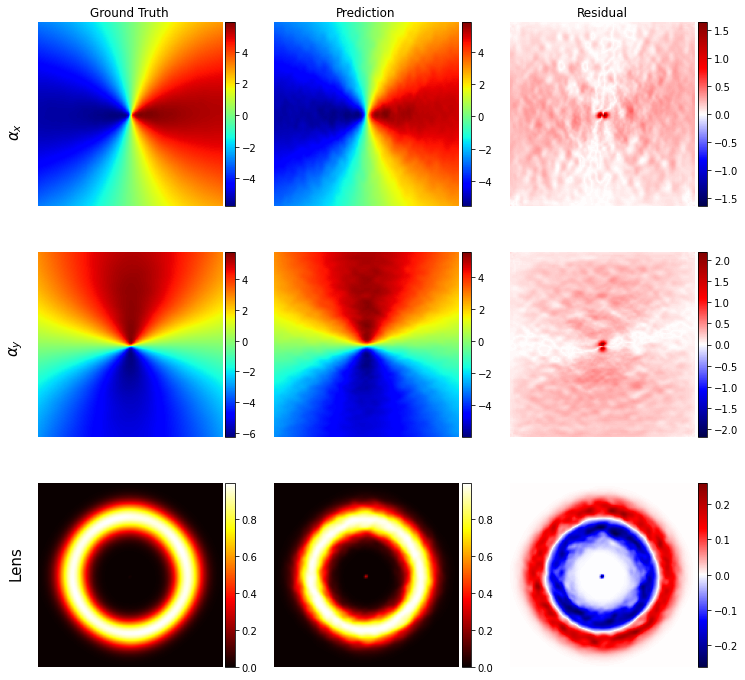

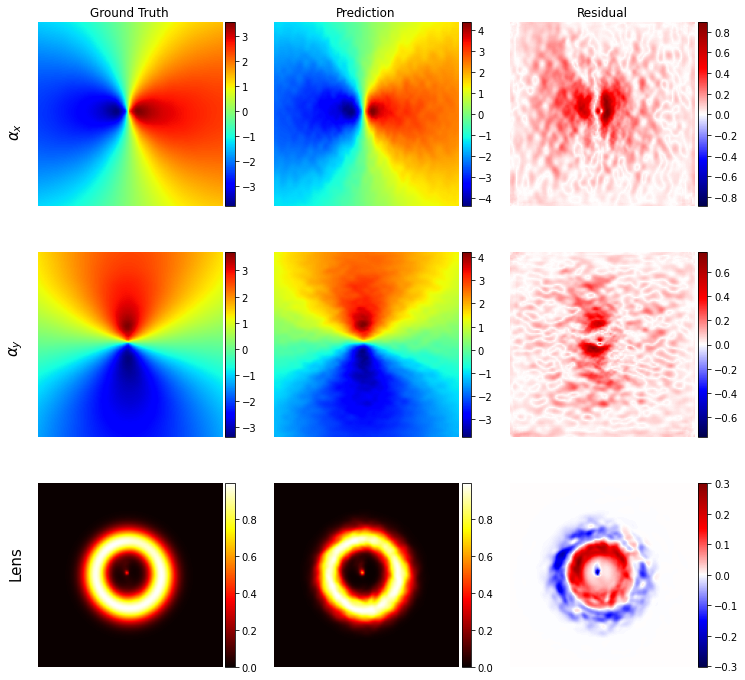

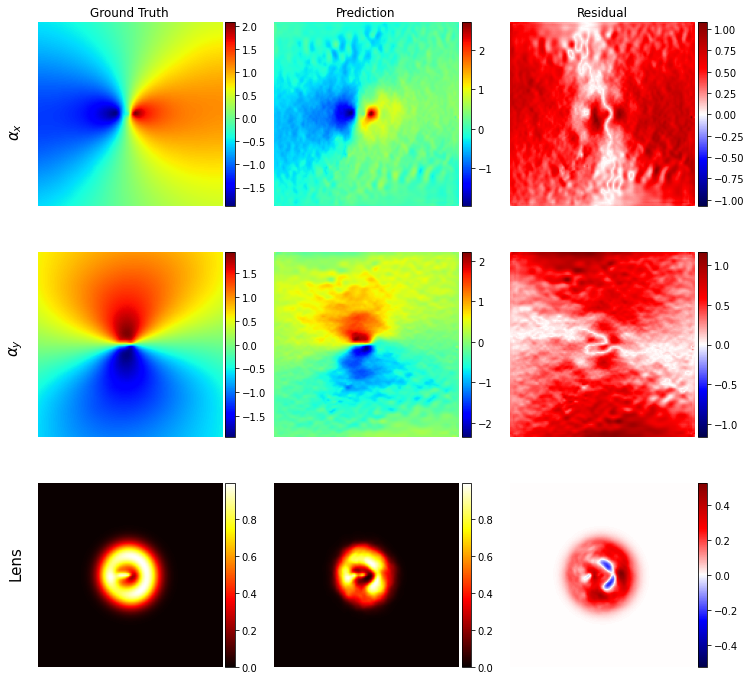

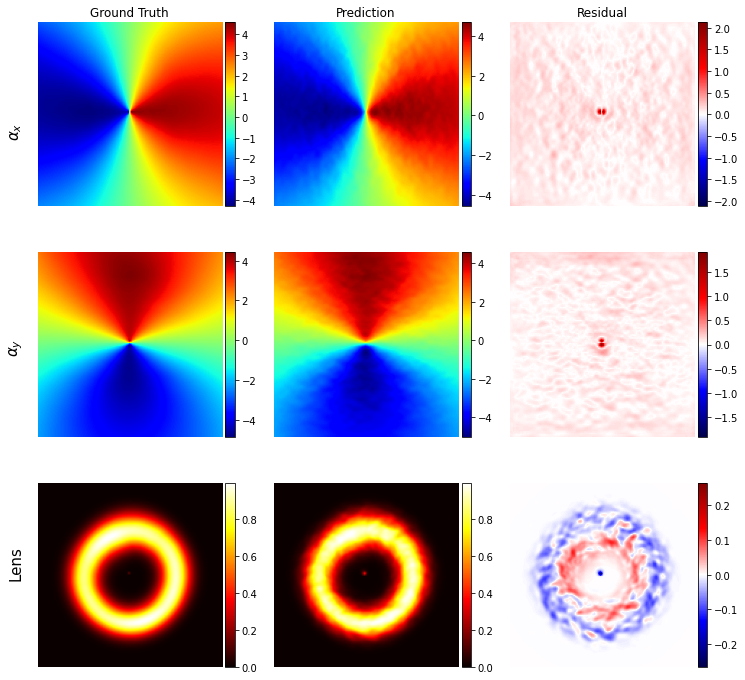

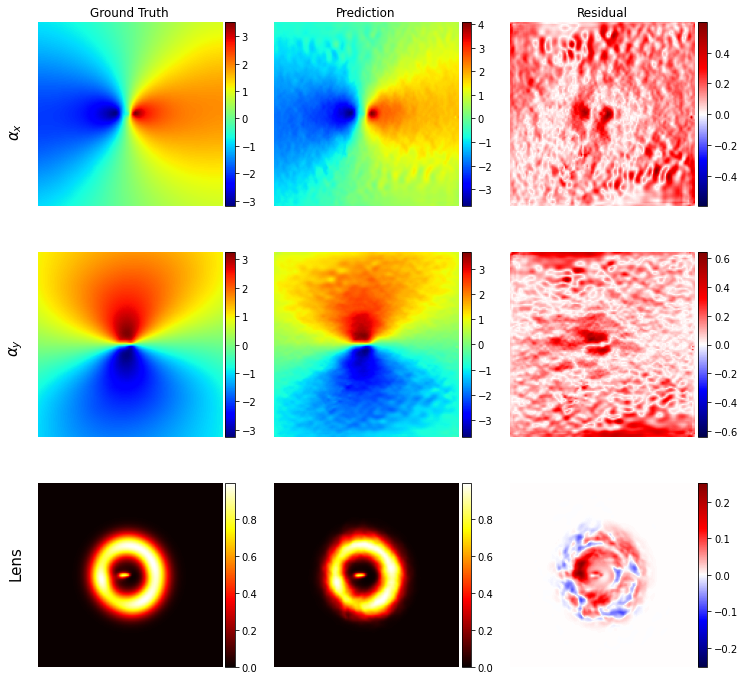

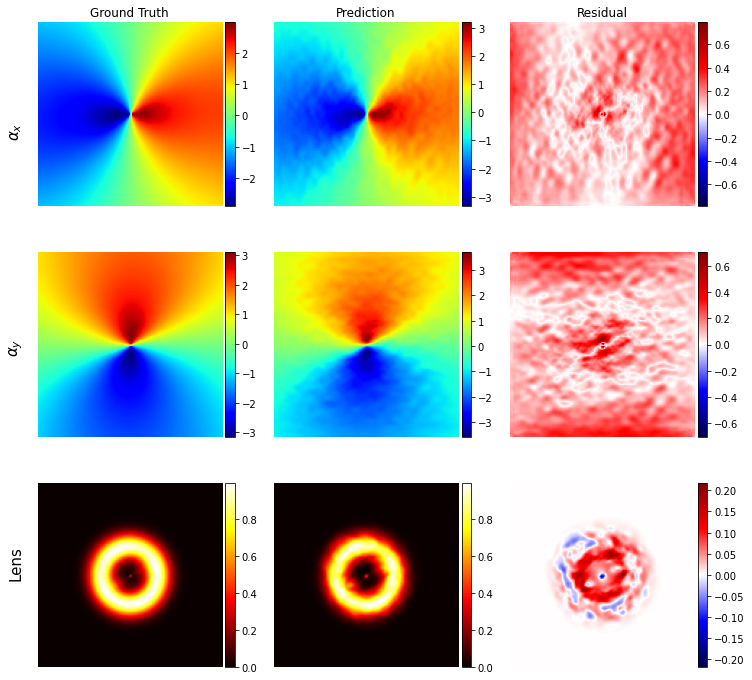

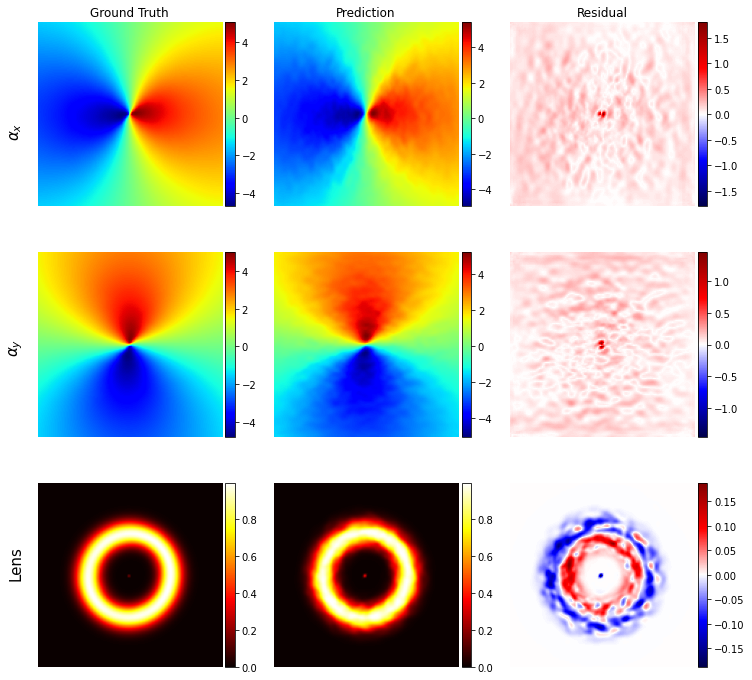

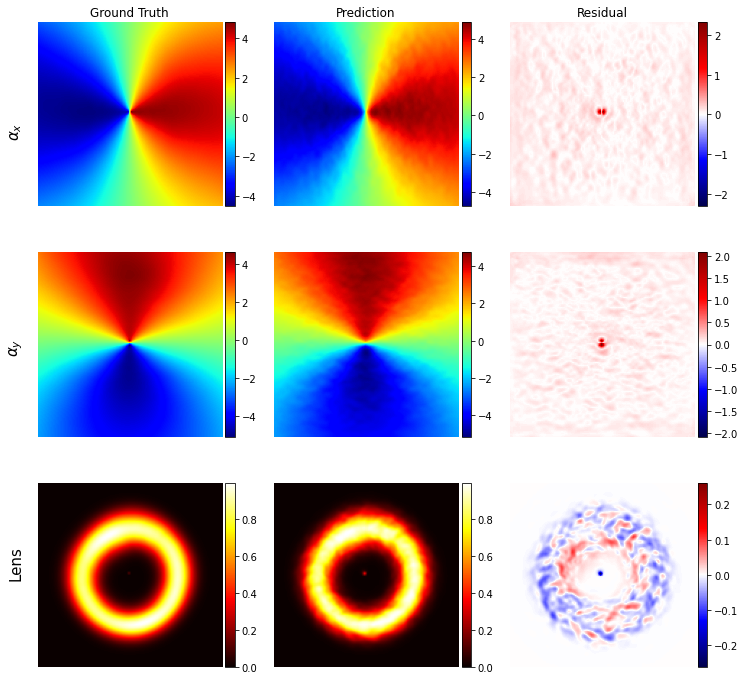

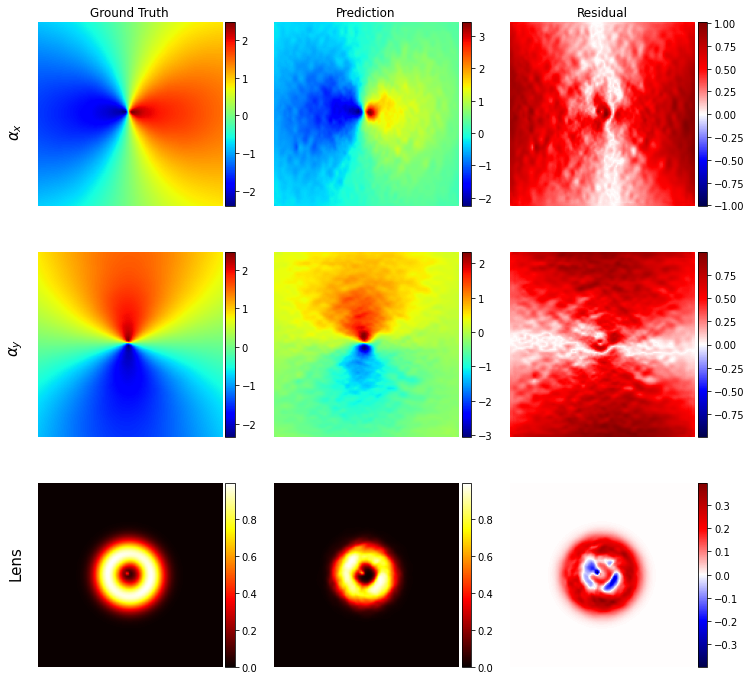

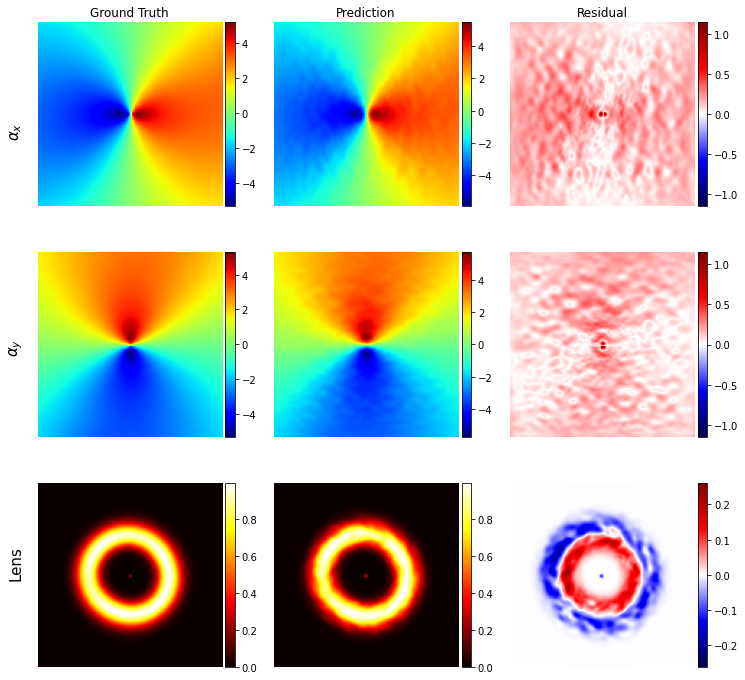

In [6]:
for batch, (kappa_true, alpha_true) in enumerate(train_dataset):
    alpha_pred = ray_tracer.call(kappa_true)
    # Lens residual
    lens_true = phys.lens_source_func(kappa_true, w=args.source_w)
    lens_pred = phys.lens_source_func_given_alpha(alpha_pred, w=args.source_w)
    train_chi_squared = tf.reduce_mean(tf.square(lens_true - lens_pred))
    for res_idx in range(args.batch_size):  # Residuals in train set
        residual_plot(alpha_true[res_idx], alpha_pred[res_idx], lens_true[res_idx], lens_pred[res_idx])
    break

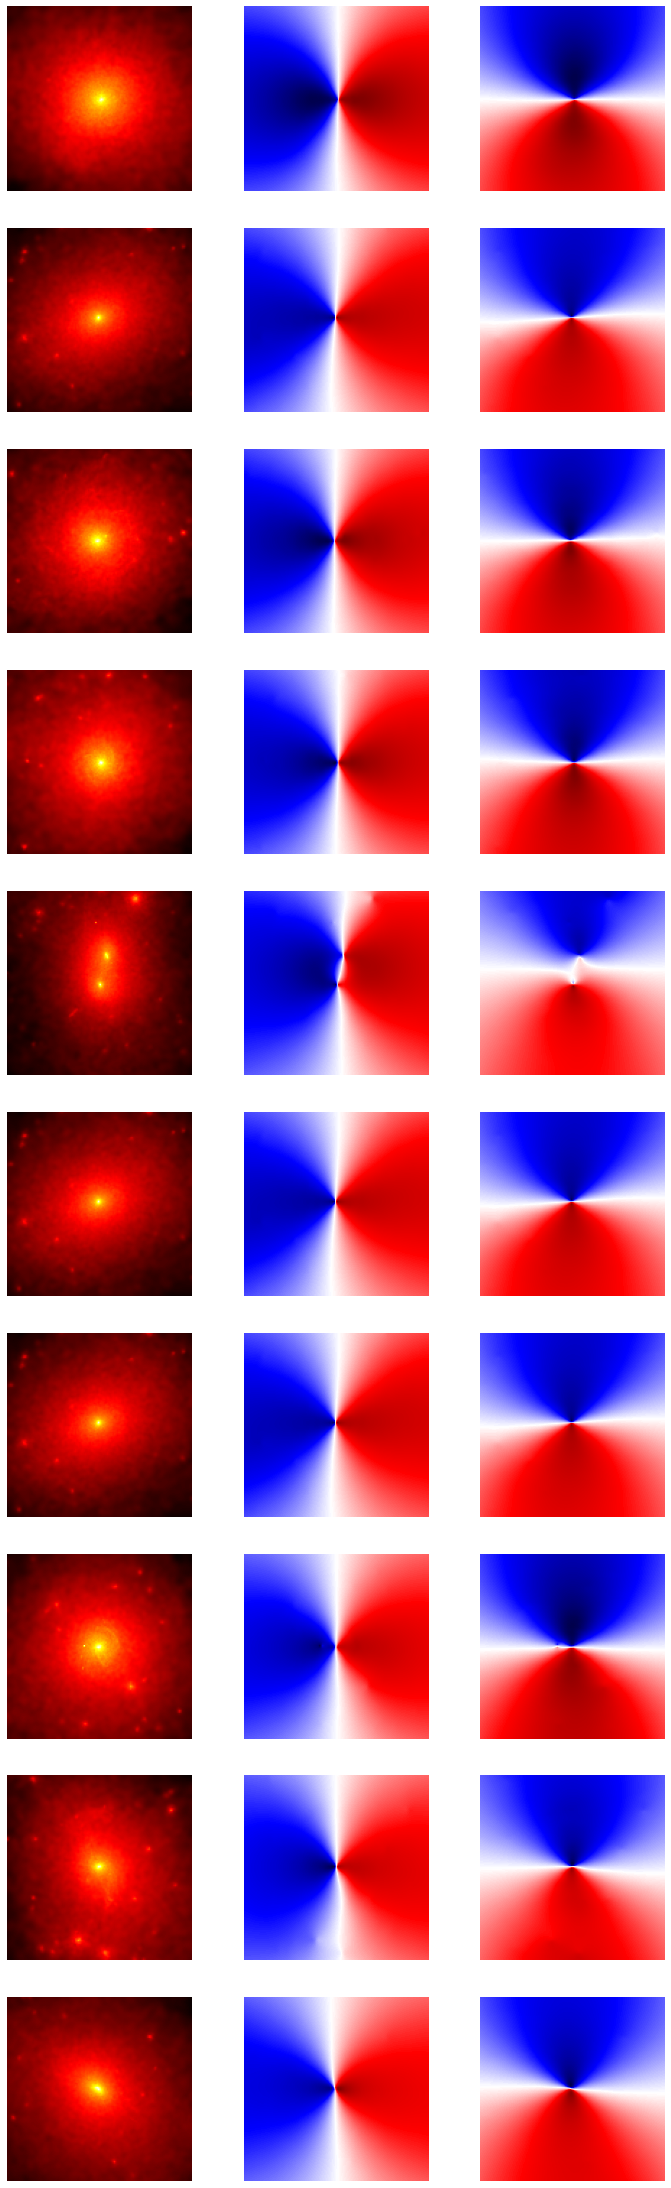

In [12]:
b = 5050
for batch, (kappa, alpha) in enumerate(train_dataset):
    if batch == b:
        break
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm


fig, axs = plt.subplots(10, 3, figsize=(12, 40))
for i in range(10):
    axs[i, 0].imshow(np.log10(kappa[i, ..., 0] + 1e-8), cmap="hot")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(alpha[i, ..., 0], cmap="seismic", norm=CenteredNorm())
    axs[i, 1].axis("off")
    axs[i, 2].imshow(alpha[i, ..., 1], cmap="seismic", norm=CenteredNorm())
    axs[i, 2].axis("off")

In [7]:
import sys
sys.argv = ['']
args = parser.parse_args(
#   f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_TNG100 {os.getenv('HOME')}/scratch/Censai/data/alpha128_NIS "\
  f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_TNG100 "\
  f"--total_items=1000 "\
  f"--epochs=50 "\
  f"--train_split=1 "\
  f"--compression_type=GZIP "\
  f"--pixels=128 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.9 "\
  f"--decay_steps=100 "\
  f"--kernel_size=5 "\
  f"--filters=82 "\
  f"--filter_scaling=1 "\
  f"--layers=4 "\
  f"--block_conv_layers=2 "\
  f"--strides=2 "\
  f"--resampling_kernel_size=7 "\
  f"--kappalog "\
#   f"--normalize "\
  f"--upsampling_interpolation "\
  f"--clipping "\
  f"--kernel_regularizer_amp=0 "\
  f"--initializer=glorot_uniform "\
  f"--batch_size=10 "\
  f"--num_parallel_reads=5 "\
  f"--cycle_length=5 "\
  f"--block_length=2 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RayTracer128_Interactive "\
  f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=10 "\
  f"--n_residuals=5 "\
  f"--patience=50 "\
  f"--tolerance=0.01 "\
  f"--seed=32 ".split()
)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
ray_tracer, phys, train_dataset, dataset = main(args)

epoch 1 | train loss 5.238e+00 | learning rate 1.00e-04 | time per step 1.23e+00 s
epoch 2 | train loss 4.723e+00 | learning rate 1.00e-04 | time per step 1.60e-02 s
epoch 3 | train loss 4.392e+00 | learning rate 1.00e-04 | time per step 7.07e-03 s
epoch 4 | train loss 3.965e+00 | learning rate 1.00e-04 | time per step 7.16e-03 s
epoch 5 | train loss 4.327e+00 | learning rate 1.00e-04 | time per step 7.08e-03 s
epoch 6 | train loss 4.125e+00 | learning rate 1.00e-04 | time per step 7.24e-03 s
epoch 7 | train loss 3.303e+00 | learning rate 1.00e-04 | time per step 7.03e-03 s
epoch 8 | train loss 3.132e+00 | learning rate 1.00e-04 | time per step 7.30e-03 s
epoch 9 | train loss 1.973e+00 | learning rate 1.00e-04 | time per step 7.21e-03 s
epoch 10 | train loss 1.434e+00 | learning rate 1.00e-04 | time per step 7.10e-03 s
epoch 11 | train loss 1.694e+00 | learning rate 1.00e-04 | time per step 7.16e-03 s
epoch 12 | train loss 1.181e+00 | learning rate 1.00e-04 | time per step 7.23e-03 s
e

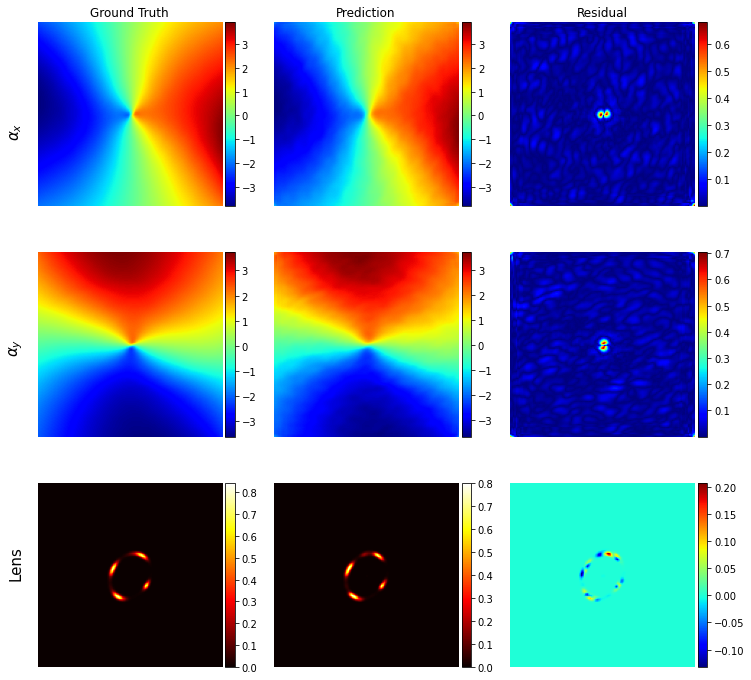

In [8]:
for batch, distributed_inputs in enumerate(train_dataset):
    for res_idx in range(args.batch_size):
        # Deflection angle residual
        alpha_true = distributed_inputs[1][res_idx, ...]
        alpha_pred = ray_tracer.call(distributed_inputs[0][res_idx, ...][None, ...])[0, ...]
        # Lens residual
        kappa = distributed_inputs[0][res_idx, ...][None, ...]
        lens_true = phys.lens_source_func(kappa)[0, ...]
        lens_pred = phys.lens_source_func_given_alpha(alpha_pred)[0, ...]
        residual_plot(alpha_true, alpha_pred, lens_true, lens_pred)
    break